The cell below describes a simple usage of mcglm, only for instilling sake.

```
from mcglm import MCGLM, mc_id

mcglm = MCGLM(   
    endog=y,   
    exog=X,   
    z=[mc_id(X)],   
    link='log',   
    variance='power'
    power=2
)   

mcglmresults = mcglm.fit()
mcglmresults.summary()

# residual analysis
plt.scatter(mcglmresults.mu, mcglmresults.pearson_residuals)
plt.xlabel('mu')
plt.ylabel('pearson residuals')
```

This notebook presents the MCGLM usage in two examples, both used for my Master's qualification.

### First Example
 
`Sleepstudy` is a study of sleep deprivation.
https://www.rdocumentation.org/packages/lme4/versions/1.1-26/topics/sleepstudy.

The study aims to study the influence of sleep deprivation on reaction time. On day 0, subjects had their usual amount of sleep. From day 0 on, they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject.

One promising approach is fitting through two-level effecting models, such as mixed models. The `mcglm` library is a perfect framework to apply this statistical learning.

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from mcglm import MCGLM, mc_mixed, mc_id
from patsy import dmatrix

In [2]:
# Top 10 cells to get an intuition about data.
sleepstudy = pd.read_csv(
    "data/first_simulation/sleepstudy.csv", dtype={"Subject": "str"}
)

sleepstudy.head(10)

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
5,414.6901,5,308
6,382.2038,6,308
7,290.1486,7,308
8,430.5853,8,308
9,466.3535,9,308


In [3]:
# General statistics about the data.
sleepstudy.describe()

,Reaction,Days
count,180.000000,180.000000
mean,298.507892,4.500000
std,56.328757,2.880293
min,194.332200,0.000000
25%,255.375825,2.000000
50%,288.650800,4.500000
75%,336.752075,7.000000
max,466.353500,9.000000


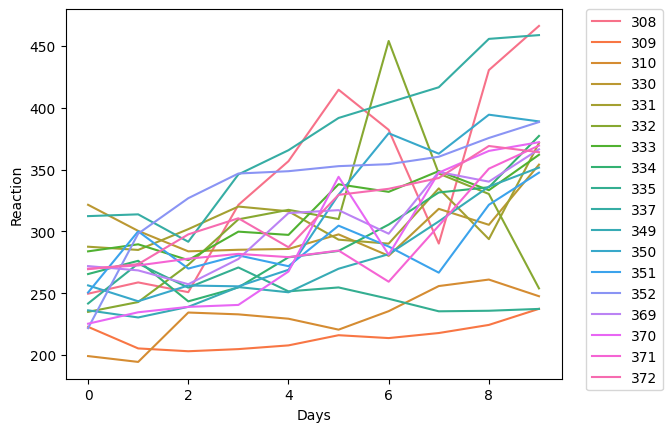

In [4]:
## Plotting curve of 18 subjects
_ = sns.lineplot(x="Days", y="Reaction", hue="Subject", data=sleepstudy)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

It is plain to see that users behave differently. Some users feel the effect of sleep deprivation, and some don't. Broadly speaking, deprivation days seem influential on reaction time.

In [8]:
# Design Matrix
X = dmatrix("~ Days", sleepstudy, return_type="dataframe")

# Z specification
Z = [mc_id(sleepstudy)] + mc_mixed(formula="~ 0 + Subject / Days", data=sleepstudy)

In [9]:
# Model fitting
mcglm = MCGLM(endog=sleepstudy["Reaction"], exog=X, z=Z)

mcglmresults = mcglm.fit()

In [10]:
mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:               Reaction   No. Iterations:                      1
Model:                          MCGLM   No. Observations:                  180
link:                        identity   Df Residuals:                      174
variance:                    constant   Df Model:                            6
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Sun, 19 Mar 2023   pAIC                           1583.94
Time:                        10:20:56   pBIC                            1603.1
                                        pLogLik                      -785.9702
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    251.4051      6.632     37.906      0.000     238.406     264.404
Days          10.4673      1.502      6.968      0.000       7.523      13.412
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1   654.9410     70.624      9.274      0.000     516.521     793.361
dispersion_2   565.5150    264.679      2.137      0.033      46.753    1084.277
dispersion_3    32.6820     13.560      2.410      0.016       6.105      59.259
dispersion_4    11.0550     42.948      0.257      0.797     -73.121      95.231
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

`Report Analysis`

#### Header
The report header brings information about parameters of mcglm, model's trait, and goodness-of-fit measurements. The default values for link and variance are `identity` and `constant`, which in this case, makes the algorithm behaves as Gaussian Mixed Models. Moreover, the goodness-of-fit measures pAIC, pBIC, and pLogLik are good information to retain: `1583.94`, `1603.1`, and `-785.97`.   

   
     
---
#### Beta coefficients  
The Beta section diagnose the fixed-effects parameters, that is to say, the conclusion overall subjects.  

    Intercept set at value 251.40. The straightforward takeaway is: At day 0, the average response time is roughly 251 seconds.
    In addition, Days at 10.46 allude to total change to response time by unit changes on Days, for subjects with random effects set to 0.
    Furthermore, by the results of the wald test on Days, we might conclude that days are statistically significant in the statistical model.
---
#### Dispersion parameters   
The Dispersion parameters allude to random effects within individuals throughout the days.  

    The first dispersion parameter is the variance across all data points. Calculated in 654.94.
    The second dispersion parameter is the variance across all intercepts, which is 565.51.
    The third dispersion parameter is the variance across all slopes. Calculated in 32.68. 
    The fourth dispersion parameter is the variance across intercepts and slopes. Calculated in 11.05.

* Moreover, the correlation might be calculated through the formula = dispersion_4/(sqrt(dispersion_2 * dispersion_3)). Cell below shows the pearson correlation result, 0.0812.   

In [11]:
import math

11.05 / (math.sqrt(565.51 * 32.68))

0.08128325928662013

Text(0, 0.5, 'pearson residuals')

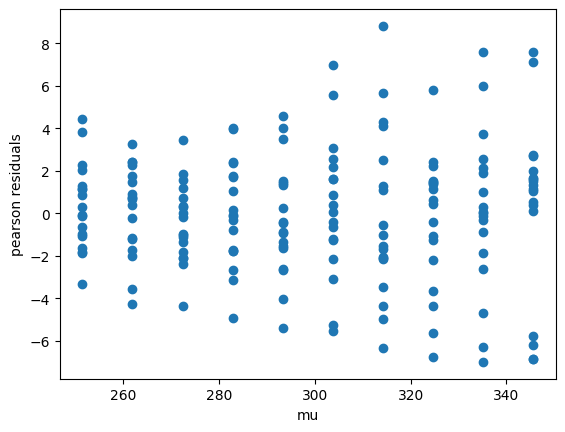

In [12]:
# Residual Analysis
plt.scatter(mcglmresults.mu, mcglmresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

Residual analysis is easy through attributes `mu` and `pearson_residue`. The model fitting looks nearly adequate since the residues aren't distributed homogeneously.   
The simple interface of `mcglm` allows to easily try different link and variance functions. As it follows, a `log`, `tweedie` model.

In [13]:
# Log and Tweedie with power 1.15
mcglm = MCGLM(
    endog=sleepstudy["Reaction"],
    exog=X,
    z=Z,
    link="log",
    variance="tweedie",
    power_fixed=True,
    power=1.5,
)

mcglmresults = mcglm.fit()

In [14]:
mcglmresults.aic, mcglmresults.bic, mcglmresults.loglikelihood

(1577.25, 1596.41, -782.6270513020747)

By the measures, these new parameters show the model is better.

Text(0, 0.5, 'pearson residuals')

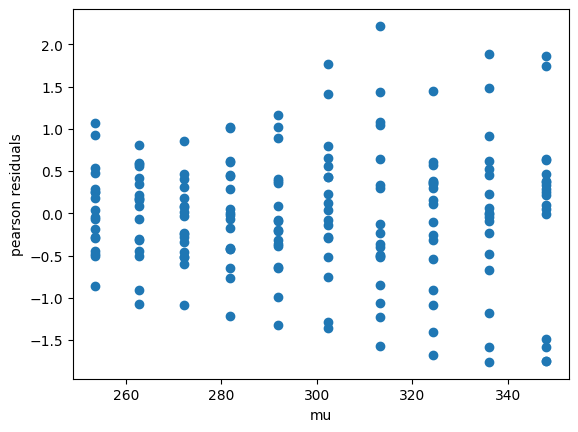

In [15]:
plt.scatter(mcglmresults.mu, mcglmresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

The residual is slightly more homogenous than the first one.

### Second Example
 
`Soya` is a dataset that stores an experiment of Universidade Federal da Grande Dourados in Dourados, Mato Grosso do Sul, Brazil. Description:    
https://github.com/walmes/wzRfun/blob/master/R/wzRfun.R#L10   
http://ccarevista.ufc.br/seer/index.php/ccarevista/article/view/1454  

The experiment collected data about different treatments of `potassium`, `water`, and `blocks` for soil farming on buckets. All of those covariates are categorical. The response traits to be analyzed are: `grain size`, `total seeds`, and `viable peas`, which stands for the weight of hundred grains, total grain per bucket, and percentage of viable peas(green beans). In the following, MCGLM fits onto this data with three unique kinds of answers: continuous, count, and binomial.

In [16]:
soya = pd.read_csv(
    "data/fourth_simulation/soya.csv",
    dtype={"block": "str", "water": "str", "pot": "str"},
)

In [17]:
# Top 10 rows of dataset
soya.head(10)

,pot,water,block,grain,seeds,viablepeas,totalpeas
0,0,37.5,I,14.55,136,22,56
1,30,37.5,I,21.51,159,2,62
2,60,37.5,I,24.62,156,0,66
3,120,37.5,I,21.88,171,2,68
4,180,37.5,I,28.11,190,0,82
5,0,50,I,17.16,140,20,63
6,30,50,I,24.44,193,6,86
7,60,50,I,28.50,200,6,94
8,120,50,I,32.94,208,7,86
9,180,50,I,28.76,237,10,97


In [18]:
# percentual of peas.
soya["viablePeas"] = soya["viablepeas"] / soya["totalpeas"]

# Design matrix.
X = dmatrix("~ block + water * pot", soya, return_type="dataframe")

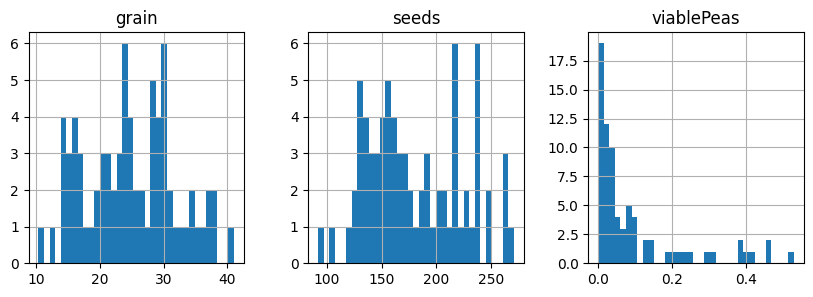

In [19]:
# histogram of target variables.
_ = soya[["grain", "seeds", "viablePeas"]].hist(bins=35, figsize=(10, 3), layout=(1,3))

Target variables `grain`, `seeds`, and `viablePeas` are continuous, count, and bounded/binomial, respectively. Three straightforward probability models for three responses are Gaussian, Poisson, and Binomial, as follows the specification for the model.  

In [20]:
# Model Specification
mcglm = MCGLM(
    endog=[soya["grain"], soya["seeds"], soya["viablePeas"]],
    exog=[X, X, X],
    z=[[mc_id(soya)], [mc_id(soya)], [mc_id(soya)]],
    link=["identity", "log", "logit"],
    variance=["constant", "tweedie", "binomialP"],
    ntrial=[None, None, soya["totalpeas"].values],
)


mcglmresults = mcglm.fit()

In [21]:
mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  grain   No. Iterations:                      3
Model:                          MCGLM   No. Observations:                   75
link:                        identity   Df Residuals:                       55
variance:                    constant   Df Model:                           20
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Sun, 19 Mar 2023   pAIC                            448.02
Time:                        10:21:24   pBIC                            516.34
                                        pLogLik                      -204.0085
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   14.2455      1.217     11.701      0.000      11.859      16.632
block[T.II]                  1.1326      0.880      1.287      0.198      -0.593       2.858
block[T.III]                -0.7797      0.880     -0.886      0.376      -2.505       0.946
block[T.IV]                 -1.5495      0.880     -1.760      0.078      -3.275       0.176
block[T.V]                  -2.3866      0.880     -2.711      0.007      -4.112      -0.661
water[T.50]                  2.1660      1.531      1.415      0.157      -0.834       5.166
water[T.62.5]                2.5404      1.531      1.660      0.097      -0.460       5.541
pot[T.120]                  11.7898      1.531      7.702      0.000       8.790      14.790
pot[T.180]                  11.8633      1.531      7.750      0.000       8.863      14.864
pot[T.30]                    6.7894      1.531      4.435      0.000       3.789       9.790
pot[T.60]                   10.3978      1.531      6.793      0.000       7.398      13.398
water[T.50]:pot[T.120]       2.2541      2.165      1.041      0.298      -1.989       6.497
water[T.62.5]:pot[T.120]     5.5826      2.165      2.579      0.010       1.340       9.826
water[T.50]:pot[T.180]       1.2097      2.165      0.559      0.576      -3.033       5.453
water[T.62.5]:pot[T.180]     9.2391      2.165      4.268      0.000       4.996      13.482
water[T.50]:pot[T.30]        0.1069      2.165      0.049      0.961      -4.136       4.350
water[T.62.5]:pot[T.30]     -1.8677      2.165     -0.863      0.388      -6.111       2.375
water[T.50]:pot[T.60]        2.6035      2.165      1.203      0.229      -1.640       6.847
water[T.62.5]:pot[T.60]      3.3585      2.165      1.551      0.121      -0.885       7.602
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     5.8610      1.671      3.507      0.000       2.586       9.136
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  seeds   No. Iterations:                      3
Model:                          MCGLM   No. Observations:                   75
link:                             log   Df Residuals:                       55
variance:                     tweedie   Df Model:                           20
Me

The three responses have generated a three-section report. As it follows, a analysis per response.

---
`grain` size.

The grain response was fitted with default parameters, `identity` and `constant`, generating a near homoscedastic linear model. Among covariates `block`, `water` and `potassium`, by Wald test, potassium levels are statistically significant for the model; the higher potassium level, bigger grain size. Variance constant on 5.862.   

Residual analysis:

Text(0, 0.5, 'pearson residuals')

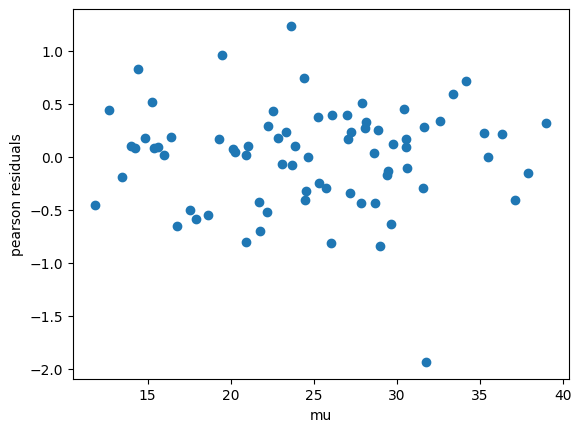

In [22]:
# grain. residual analysis
plt.scatter(mcglmresults.mu[0], mcglmresults.pearson_residuals[0])
plt.xlabel("mu")
plt.ylabel("pearson residuals")

The fitting seems pretty good.

---
`seed` count.

As long as seed is a count variable, a straightforward and canonical way to model it is Poisson. Two out of three covariates are statistically significant on `seed`: potassium, for every level; and black for level V.

Residual analysis:

Text(0, 0.5, 'pearson residuals')

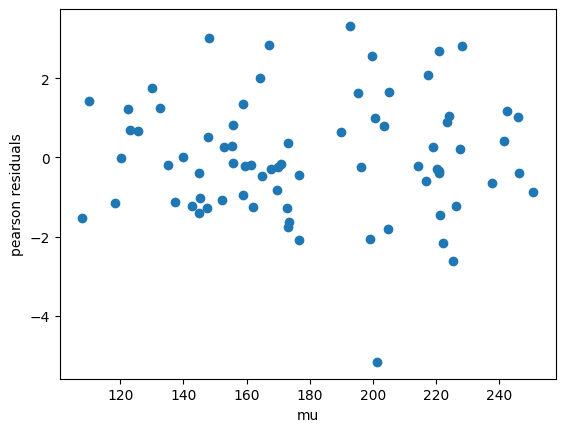

In [23]:
# seeds. residual analysis
plt.scatter(mcglmresults.mu[1], mcglmresults.pearson_residuals[1])
plt.xlabel("mu")
plt.ylabel("pearson residuals")

Notwithstanding the possible outlier, the fit seems pretty good.

---
Percentage of `viable peas`.

Binomial N trials is the adequate model for bounded data. Perhaps, the most popular solution to fit is the `Logit` link, the one used. Among covariates, only potassium level 30, and water level 50 are statistically significant with Viable Peas.

Residual Analysis:

Text(0, 0.5, 'pearson residuals')

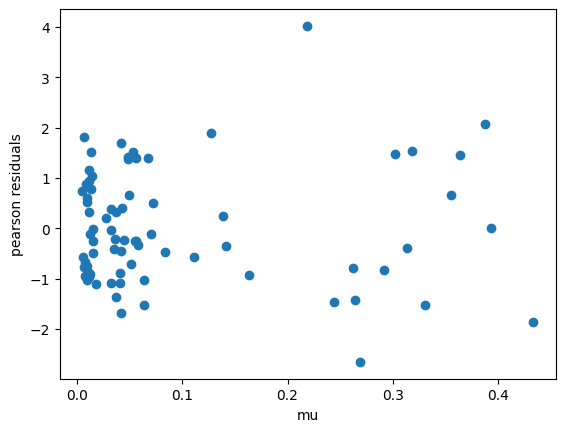

In [24]:
# viablepeasP. residual analysis
plt.scatter(mcglmresults.mu[2], mcglmresults.pearson_residuals[2])
plt.xlabel("mu")
plt.ylabel("pearson residuals")

Trying out a few different link and variance functions is seamless in the mcglm library.

The last three components rhos allude to the correlation coefficient among responses. 
 * rho_1 stands for grain size and whole seeds, with a considerable Pearson correlation of 0.63.
 * rho_2 and rho_3 stand for correlation between grain size and viable peas, seed count, and viable peas, respectively. Both correlations are low. 